# Speed comparison of different tensors

## Imports

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../')
import torch
import numpy as np
import pyopencl as cl
# import tensors
from lightgrad.autograd import Gradients
from lightgrad.autograd import CpuTensor
from lightgrad.autograd import OpenCLTensor, OpenCLDevice
# helpers
from timeit import timeit
from tqdm.notebook import tqdm
# opencl device
d = OpenCLDevice(device_type=cl.device_type.GPU)
d.context

Populating the interactive namespace from numpy and matplotlib


<pyopencl.Context at 0x191b446fc50 on <pyopencl.Device 'GeForce GPU' on 'NVIDIA CUDA' at 0x191b1b9b9f0>>

## Helpers

In [2]:
class Benchmark(object):
    def __init__(self, sizes, ntensors=1, ndim=1, device=d, num_iter=100):
        self.sizes = tuple(sizes)
        self.ntensors = ntensors
        self.ndim = ndim
        self.num_iter = num_iter
        self.device = device
        # timing arrays
        self.cpu_times = []
        self.cl_times = []
        self.torch_times = []
        # iterator variables
        self.torch_tensors = []
        self.cpu_tensors = []
        self.cl_tensors = []
        self.i = 0

    @staticmethod
    def fn(*tensors):
        raise NotImplementedError()
    @staticmethod
    def prep_fn(*t):
        return tuple(t)
    @classmethod
    def torch_fn(cls, *t):
        cls.fn(*t)
        torch.cuda.synchronize()
    @classmethod
    def prep_fn_dispatch(cls, *t):
        ts = cls.prep_fn(*t)
        return ts if isinstance(ts, (tuple, list)) else (ts,)
        
    def __iter__(self):
        self.i = 0
        # clear time lists
        self.cpu_times.clear()
        self.cl_times.clear()
        self.torch_times.clear()
        # clear tensor lists
        self.torch_tensors.clear()
        self.cpu_tensors.clear()
        self.cl_tensors.clear()
        # maximum shape
        max_shape = (max(self.sizes),) * self.ndim
        # create all tensors
        for _ in range(self.ntensors):
            np_tensor = np.random.uniform(-1, 1, size=max_shape).astype(np.float32)
            # create tensors from numpy array
            self.cpu_tensors.append(CpuTensor.from_numpy(np_tensor))
            self.cl_tensors.append(OpenCLTensor.from_numpy(np_tensor, device=self.device))
            self.torch_tensors.append(torch.Tensor(np_tensor).cuda())
        # precompile all opencl kernels
        self.__class__.fn(*self.__class__.prep_fn_dispatch(*self.cl_tensors))
        return self
    def __next__(self):
        if self.i >= len(self):
            # clean up
            self.torch_tensors.clear()
            self.cpu_tensors.clear()
            self.cl_tensors.clear()
            raise StopIteration
        s = self.sizes[self.i]
        idx = (slice(0, s),) * self.ndim
        # get sub tensors of current size
        cpu_subs = tuple(self.__class__.prep_fn_dispatch(*(t[idx] for t in self.cpu_tensors)))
        cl_subs = tuple(self.__class__.prep_fn_dispatch(*(t[idx] for t in self.cl_tensors)))
        torch_subs = tuple(self.__class__.prep_fn_dispatch(*(t[idx] for t in self.torch_tensors)))
        # timeit
        self.timeit(cpu_subs, cl_subs, torch_subs)
        # clean up
        del cpu_subs, cl_subs, torch_subs
        # return iteration number just to return something
        self.i += 1
        return self.i
    
    def timeit(self, cpu_tensors, cl_tensors, torch_tensors):
        # execute and measure times
        cpu_time = timeit(lambda: self.__class__.fn(*cpu_tensors), number=self.num_iter)
        cl_time = timeit(lambda: self.__class__.fn(*cl_tensors), number=self.num_iter)
        torch_time = timeit(lambda: self.__class__.torch_fn(*torch_tensors), number=self.num_iter)
        # add to lists
        self.cpu_times.append(cpu_time)
        self.cl_times.append(cl_time)
        self.torch_times.append(torch_time)
                    
    def __len__(self):
        return len(self.sizes)
        
    def plot(self, additional_times={}):
        figsize(8, 4)
        figure()
        grid()
        title(self.__class__.__name__)
        ticks = [s ** self.ndim for s in self.sizes]
        # plot tracked times
        plot(ticks, self.cpu_times, label="cpu")
        plot(ticks, self.cl_times, label="opencl")
        plot(ticks, self.torch_times, label="torch")
        # plot additional times
        for name, times in additional_times.items():
            plot(ticks, times, label=name)
        legend()
        xlabel("Number of Elements")
        ylabel("Time in s")
        show()
        
    def execute_and_plot(self, use_tqdm=True, disable_gradients=True):
        from contextlib import ExitStack
        with ExitStack() as stack:
            if disable_gradients:
                stack.enter_context(torch.no_grad())
                stack.enter_context(Gradients.no_grad())
            list(iter(self) if not use_tqdm else tqdm(iter(self)))
        self.plot()
        
class Benchmark_with_transposed(Benchmark):
    def __init__(self, sizes, ntensors=2, device=d, num_iter=100):
        Benchmark.__init__(self, sizes, ntensors=ntensors, ndim=2, device=device, num_iter=num_iter)
        self.cl_transposed_times = []
    def __iter__(self):
        self.cl_transposed_times.clear()
        return Benchmark.__iter__(self)
    def timeit(self, cpu_tensors, cl_tensors, torch_tensors):
        # do parent benchmarking
        Benchmark.timeit(self, cpu_tensors, cl_tensors, torch_tensors)
        # additionally time function with last tensor being transposed
        cl_tensors = cl_tensors[:-1] + (cl_tensors[-1].transpose(1, 0).detach(),)
        cl_transposed_time = timeit(lambda: self.__class__.fn(*cl_tensors), number=self.num_iter)
        self.cl_transposed_times.append(cl_transposed_time)
    def plot(self, additional_times={}):
        additional_times.update({'opencl_transposed': self.cl_transposed_times})
        Benchmark.plot(self, additional_times)

In [3]:
# helpers to handle differences between pytorch and lightgrad
# TODO: backward is pretty unfair because pytorch does an additional summation
backward = lambda t: t.sum().backward(retain_graph=True) if isinstance(t, torch.Tensor) else t.backward(True)
detach = lambda t: t.detach().requires_grad_(True) if isinstance(t, torch.Tensor) else t.detach()

# Unary Operators

In [4]:
d.mem_pool.free_held()
sizes = np.linspace(16, 512**2, num=30).astype(np.int32)

## Forward

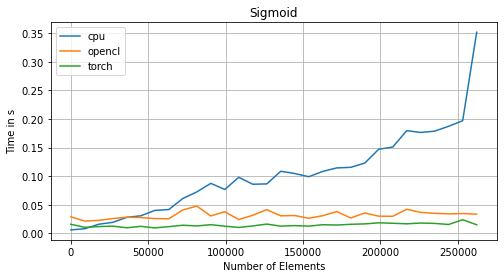

In [5]:
Sigmoid = type("Sigmoid", (Benchmark,), {'fn': lambda ts: ts.sigmoid()})
Sigmoid(sizes).execute_and_plot()

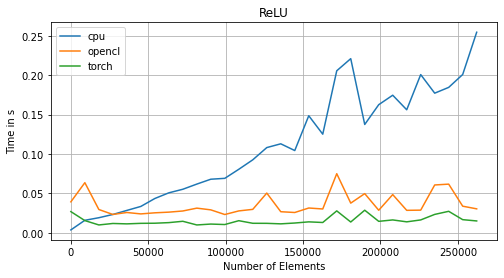

In [6]:
Sigmoid = type("ReLU", (Benchmark,), {'fn': lambda t: t.relu()})
Sigmoid(sizes).execute_and_plot()

## Backward

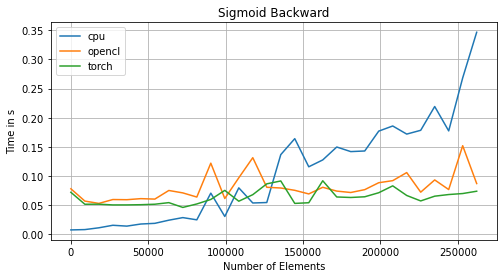

In [7]:
Sigmoid_back = type("Sigmoid Backward", (Benchmark,), {'fn': backward, 'prep_fn': lambda t: detach(t).sigmoid()})
Sigmoid_back(sizes).execute_and_plot(disable_gradients=False)

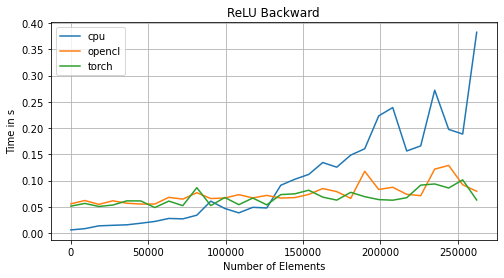

In [8]:
ReLU_back = type("ReLU Backward", (Benchmark,), {'fn': backward, 'prep_fn': lambda t: detach(t).relu()})
ReLU_back(sizes).execute_and_plot(disable_gradients=False)

# Binary Operators

In [9]:
d.mem_pool.free_held()
sizes = np.linspace(32, 1024, num=30).astype(np.int32) # actually will be squarred

## Forward
Also tracking timeing of addition with tranposed. Transposition leads to different strides in A and B which slows down the data accesses for the kernel.

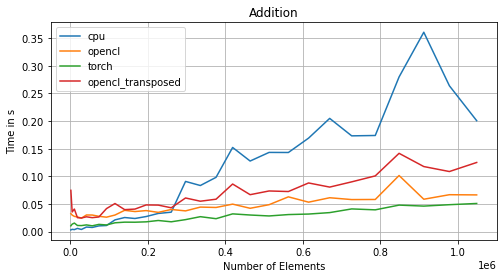

In [10]:
Add = type("Addition", (Benchmark_with_transposed,), {'fn': lambda a, b: a + b})
Add(sizes).execute_and_plot()

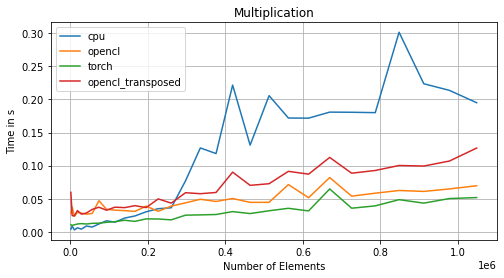

In [11]:
Mul = type("Multiplication", (Benchmark_with_transposed,), {'fn': lambda a, b: a * b})
Mul(sizes).execute_and_plot()

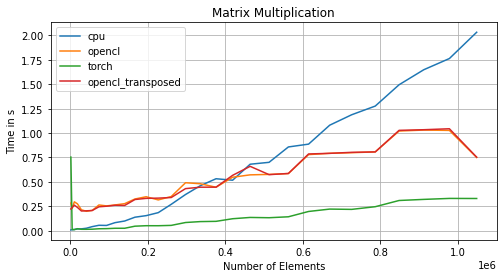

In [12]:
MatMul = type("Matrix Multiplication", (Benchmark_with_transposed,), {'fn': lambda a, b: a @ b})
MatMul(sizes).execute_and_plot()

## Backward

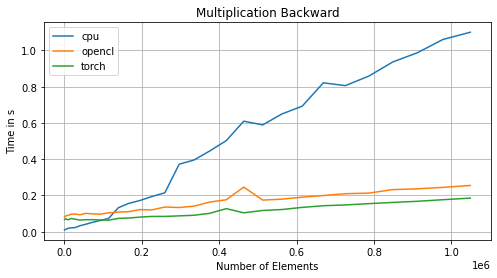

In [13]:
MulBack = type("Multiplication Backward", (Benchmark,), {'fn': backward, 'prep_fn': lambda a, b: detach(a) * detach(b)})
MulBack(sizes, ntensors=2, ndim=2).execute_and_plot(disable_gradients=False)

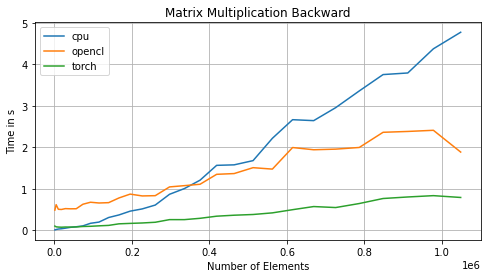

In [14]:
MatMulBack = type("Matrix Multiplication Backward", (Benchmark,), {'fn': backward, 'prep_fn': lambda a, b: detach(a) @ detach(b)})
MatMulBack(sizes, ntensors=2, ndim=2).execute_and_plot(disable_gradients=False)

# Reductions

In [15]:
d.mem_pool.free_held()
sizes = np.linspace(32, 2048, num=15).astype(np.int32) # actually will be squarred

## Forward
- We also track times for summation over specific axis. This shows the influence of non-coalescent accesses to global memory.
- Reduction over non-contiguous dimensions is still quiet slow

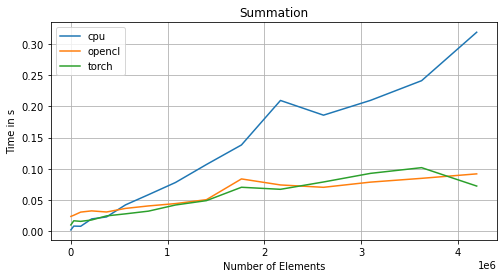

In [16]:
Sum = type("Summation", (Benchmark,), {'fn': lambda t: t.sum()})
Sum(sizes, ndim=2).execute_and_plot()

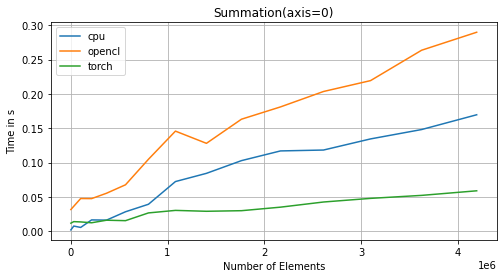

In [17]:
Sum = type("Summation(axis=0)", (Benchmark,), {'fn': lambda t: t.sum(axis=0)})
Sum(sizes, ndim=2).execute_and_plot()

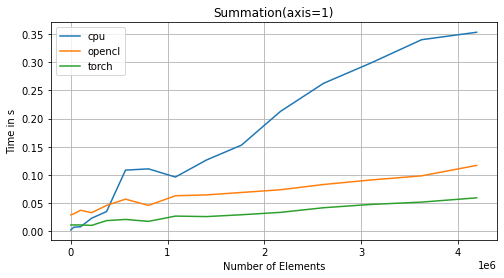

In [18]:
Sum = type("Summation(axis=1)", (Benchmark,), {'fn': lambda t: t.sum(axis=1)})
Sum(sizes, ndim=2).execute_and_plot()